In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc

In [2]:
""" Read the data and return it as an array (n, m) where n is the nbr of channels (time, wavelength(s), temperature...) 
and m the nbr of datapoints from a python readout of the WLM. Check that each mesure has the amount of channel fixed by 
the first line and that there is no reset of the time (else compensate for it) """
def ReadDataPythonReadOut(path_name):
    with open(path_name, 'r') as file:
        Data = file.read()

    Data = Data.split("\n")

    # Initialize
    res = np.zeros((len(Data[0].split(" ")), len(Data)))
    try:
        res[:, 0] = np.array(Data[0].split(" "), dtype=float)    
    except: # If error in reading (not everything is measured), return nothing
        print("Error initialization")
        return res
    
    time_offset = 0 # If time reinitialized, keep time increasing

    # Import the data line by line
    for i in range(1, len(Data)):
        try:
            res[:, i] = np.array(Data[i].split(" "), dtype=float)

            # Fix jumping time
            res[0, i] = res[0, i] + time_offset
            if res[0, i] < res[0, i-1]: # Time is not increasing
                time_offset = res[0, i-1] + np.mean(res[0, 1:i]-res[0, :i-1]) # Time reset -> offset = previous time + mean DeltaT
                res[0, i] = time_offset
                print("Time problem line "+str(i))

        except: # If error in reading (not everything is measured), put -1 for the time
            print("Error line "+str(i))
            res[0, i] = -1
    return res

In [14]:
path_name = r"Z:\Users\Remy\PID_Laser\PythonReadOut\SavedData\NoPID\DataWeekend_2025_09_26_Lambda_P_T_temp1.txt"
cutoff_std_lambda = 10 # Distance from mean above which data is absurd
# T, Lambda = ReadDataPythonReadOut(path_name)
# T, Lambda = T[T!=-1], Lambda[T!=-1]
T, Lambda, Pressure, Temperature = ReadDataPythonReadOut(path_name)
T, Lambda, Pressure, Temperature = T[T!=-1], Lambda[T!=-1], Pressure[T!=-1], Temperature[T!=-1] # Remove lines where every channel was not saved
Absurd_Lambda = np.abs(Lambda-np.mean(Lambda))<cutoff_std_lambda # Remove the data points where the wavelength distance from the mean is bigger than cutoff_std_lambda
T_clean, Lambda_clean, Pressure_clean, Temperature_clean = T[Absurd_Lambda], Lambda[Absurd_Lambda], Pressure[Absurd_Lambda], Temperature[Absurd_Lambda]
plot_step = 100 # Plot one point every plot_step

Time problem line 2055
Error line 1245055


# Plot evolution

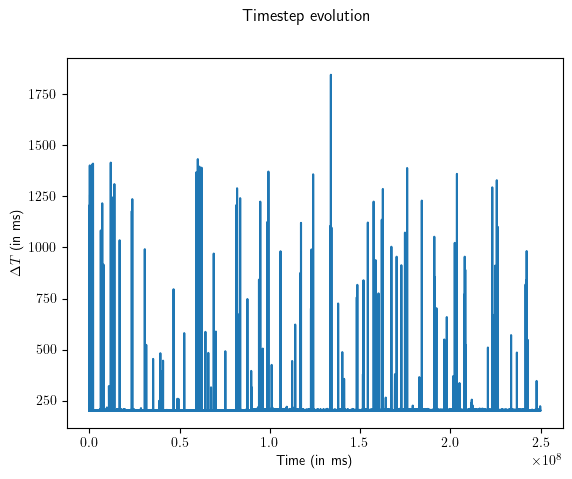

In [15]:
%matplotlib inline
plt.close()
plt.figure()
plt.plot(T[1:], T[1:]-T[0:-1])
plt.xlabel("Time (in ms)")
plt.ylabel(r"$\Delta T$ (in ms)")
plt.suptitle("Timestep evolution")
plt.show()

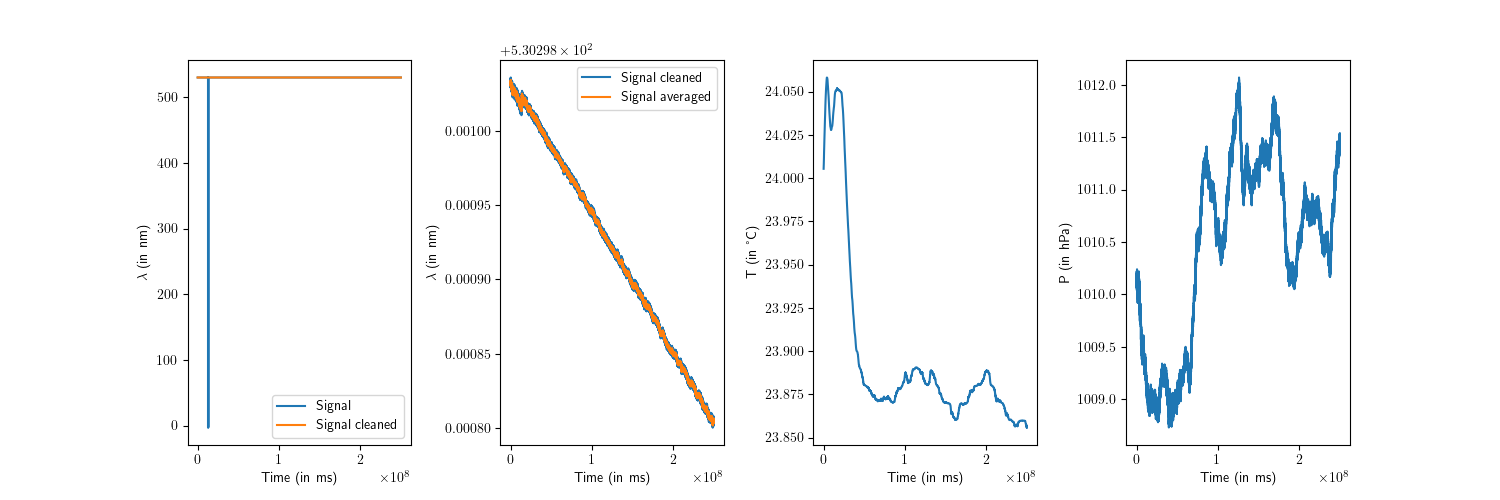

In [16]:
width_mean = int(1e1)
if len(Lambda_clean)%width_mean == 0: # No need to cut Lambda
    Mean_Lambda = np.mean(np.reshape(Lambda_clean, (len(Lambda_clean)//width_mean, width_mean)), axis=1)
    T_Mean = T_clean[::width_mean]
else:
    Mean_Lambda = np.mean(np.reshape(Lambda_clean[:-(len(Lambda_clean)%width_mean)], (len(Lambda_clean)//width_mean, width_mean)), axis=1)
    T_Mean = T_clean[:-(len(Lambda_clean)%width_mean):width_mean]

%matplotlib widget
plt.close()
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
fig.subplots_adjust(wspace=0.4)
axes[0].plot(T, Lambda, label="Signal")
axes[0].plot(T_clean, Lambda_clean, label="Signal cleaned")
axes[0].legend()
axes[0].set_xlabel("Time (in ms)")
axes[0].set_ylabel(r"$\lambda$ (in nm)")

axes[1].plot(T_clean, Lambda_clean, label="Signal cleaned")
axes[1].plot(T_Mean, Mean_Lambda, label="Signal averaged")
axes[1].legend()
axes[1].set_xlabel("Time (in ms)")
axes[1].set_ylabel(r"$\lambda$ (in nm)")

axes[2].plot(T, Temperature)
axes[2].set_xlabel("Time (in ms)")
axes[2].set_ylabel("T (in °C)")

axes[3].plot(T, Pressure)
axes[3].set_xlabel("Time (in ms)")
axes[3].set_ylabel("P (in hPa)")
plt.show()

# FFT cleaned signal (not averaged)

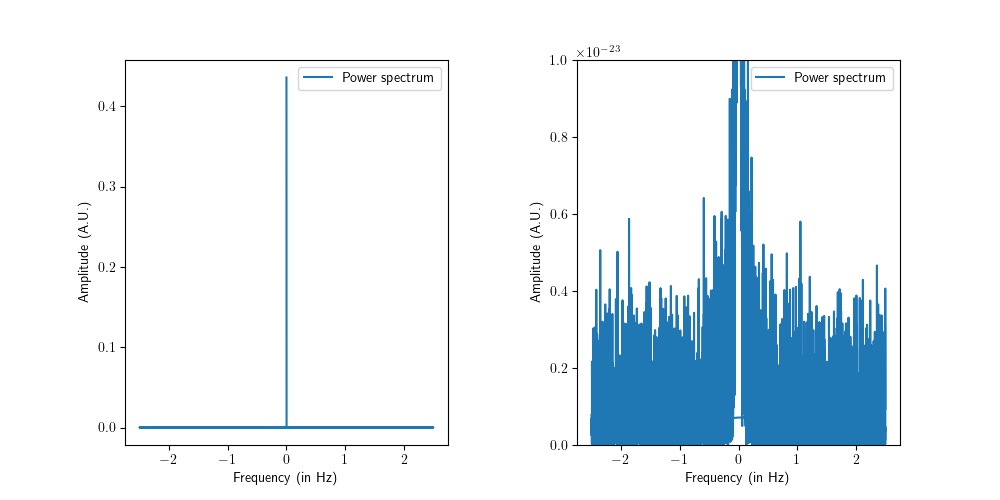

In [17]:
FT_Lambda_clean = np.fft.fft(Lambda_clean*1e-9) # In m.s
fs = 1000*(len(T_clean)-1)/T_clean[-1] # In Hz
Freq = np.fft.fftfreq(len(T_clean), d=1/fs)

%matplotlib widget
plt.close()
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.4)
axes[0].plot(Freq[0::plot_step], np.abs(FT_Lambda_clean[0::plot_step])**2, label="Power spectrum")
axes[0].legend()
axes[0].set_xlabel("Frequency (in Hz)")
axes[0].set_ylabel("Amplitude (A.U.)")

axes[1].plot(Freq[0::plot_step], np.abs(FT_Lambda_clean[0::plot_step])**2, label="Power spectrum")
axes[1].legend()
axes[1].set_xlabel("Frequency (in Hz)")
axes[1].set_ylabel("Amplitude (A.U.)")
axes[1].set_ylim(0, 1e-23)
plt.show()

# FFT cleaned signal (not averaged) without the offset

In [19]:
Lambda_clean_no_offset = Lambda_clean - np.mean(Lambda_clean)
FT_Lambda_clean_no_offset = np.fft.fft(Lambda_clean_no_offset*1e-9) # In m.s
fs = 1e3*(len(T_clean)-1)/T_clean[-1] # In Hz
Freq = np.fft.fftfreq(len(T_clean), d=1/fs)

%matplotlib inline
plt.rcParams['text.usetex'] = True
plt.close()
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
fig.subplots_adjust(wspace=0.4)

axes[0].plot(T_clean[0::plot_step], Lambda_clean_no_offset[0::plot_step])
axes[0].set_xlabel("Time (in ms)")
axes[0].set_ylabel(r"$\lambda - \braket{\lambda}$ (in nm)")

axes[1].plot(Freq[0::plot_step], np.abs(FT_Lambda_clean_no_offset[0::plot_step])**2, label="Power spectrum")
axes[1].legend()
axes[1].set_xlabel("Frequency (in Hz)")
axes[1].set_ylabel("Amplitude (A.U.)")

axes[2].plot(Freq[0::plot_step], np.abs(FT_Lambda_clean_no_offset[0::plot_step])**2, label="Power spectrum")
axes[2].legend()
axes[2].set_xlabel("Frequency (in Hz)")
axes[2].set_ylabel("Amplitude (A.U.)")
axes[2].set_ylim(0, 1e-24)
plt.show()

RuntimeError: latex was not able to process the following string:
b'$\\\\lambda - \\\\braket{\\\\lambda}$ (in nm)'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error file.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.24 (MiKTeX 22.7.30) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(file.tex
LaTeX2e <2022-06-01> patch level 5
L3 programming layer <2022-07-15>
(C:\Users\Joschka\AppData\Local\Programs\MiKTeX\tex/latex/base\article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(C:\Users\Joschka\AppData\Local\Programs\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\Joschka\AppData\Local\Programs\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Users\Joschka\AppData\Local\Programs\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Users\Joschka\AppData\Local\Programs\MiKTeX\tex/latex/base\t1cmr.fd))
(C:\Users\Joschka\AppData\Local\Programs\MiKTeX\tex/latex/base\inputenc.sty)
(C:\Users\Joschka\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Users\Joschka\AppData\Local\Programs\MiKTeX\tex/latex/graphics\keyval.sty)
(C:\Users\Joschka\AppData\Local\Programs\MiKTeX\tex/generic/iftex\ifvtex.sty
(C:\Users\Joschka\AppData\Local\Programs\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Users\Joschka\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.cfg
))
(C:\Users\Joschka\AppData\Local\Programs\MiKTeX\tex/latex/underscore\underscore
.sty)
(C:\Users\Joschka\AppData\Local\Programs\MiKTeX\tex/latex/base\textcomp.sty)
(C:\Users\Joschka\AppData\Local\Programs\MiKTeX\tex/latex/l3backend\l3backend-d
vips.def)
No file file.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
l.29 {\sffamily $\lambda - \braket
                                  {\lambda}$ (in nm)}%
No pages of output.
Transcript written on file.log.




<Figure size 1000x500 with 3 Axes>

# Brouillons

In [8]:
# """ Read the data and return it as an array (n, m) where n is the nbr of channels (time, wavelength(s), temperature...) 
# and m the nbr of datapoints from a python readout of the WLM """
# def ReadDataPythonReadOut(path_name):
#     with open(path_name, 'r') as file:
#         Data = file.read()

#     Data = Data.split("\n")

#     # Initialize
#     res = np.zeros((len(Data[0].split(" ")), len(Data)))
#     try:
#         res[:, 0] = np.array(Data[0].split(" "), dtype=float)    
#     except: # If error in reading (not everything is measured), return nothing
#         print("Error initialization")
#         return res

#     # Import the data line by line
#     for i in range(1, len(Data)):
#         try:
#             res[:, i] = np.array(Data[i].split(" "), dtype=float)
#             if res[0, i] < res[0, i-1]: # Time is not increasing
#                 res[0, i] = -1
#                 print("Time problem line "+str(i))
#         except: # If error in reading (not everything is measured), put -1 for the time
#             print("Error line "+str(i))
#             res[0, i] = -1
#     return res


# # Check that there is no time issue
# DeltaT = T[1:]-T[0:-1]
# CheckDeltaT = np.concatenate(([True], DeltaT>0))
# T, Lambda, Pressure, Temperature = T[CheckDeltaT], Lambda[CheckDeltaT], Pressure[CheckDeltaT], Temperature[CheckDeltaT]

# FT_Lambda = sc.fft.fft(Lambda_clean*1e-9) # In m
# t_step = np.mean(T[1:]-T[:-1])*1e-3 # In s
# Freq = sc.fft.fftfreq(len(T_clean), t_step)[:len(T_clean)//2]


# %matplotlib widget
# plt.close()
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# fig.subplots_adjust(wspace=0.4)
# axes[0].plot(Freq, np.abs(FT_Lambda[:len(T_clean)//2])**2, label="Power spectrum")
# axes[0].legend()
# axes[0].set_xlabel("Frequency (in Hz)")
# axes[0].set_ylabel("Amplitude (A.U.)")

# axes[1].plot(Freq, np.abs(FT_Lambda[:len(T_clean)//2])**2, label="Power spectrum")
# axes[1].legend()
# axes[1].set_xlabel("Frequency (in Hz)")
# axes[1].set_ylabel("Amplitude (A.U.)")
# axes[1].set_ylim(0, 1e-24)
# plt.show()